In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_processing import ImagesDataset
import torch
from torchvision import models
from torch.cuda.amp import autocast, GradScaler





In [2]:
# Define transformations (normalization and augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = r'UCMerced_LandUse/Images' 
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Class names
class_names = dataset.classes
num_classes = len(class_names)

print(f"Dataset Loaded: {len(dataset)} images across {num_classes} classes.")



Dataset Loaded: 2100 images across 21 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.0136
Epoch 2/10, Loss: 0.5933
Epoch 3/10, Loss: 0.4885
Epoch 4/10, Loss: 0.2834
Epoch 5/10, Loss: 0.1954
Epoch 6/10, Loss: 0.1937
Epoch 7/10, Loss: 0.2776
Epoch 8/10, Loss: 0.4128
Epoch 9/10, Loss: 0.2306
Epoch 10/10, Loss: 0.1885
Test Accuracy: 90.00%


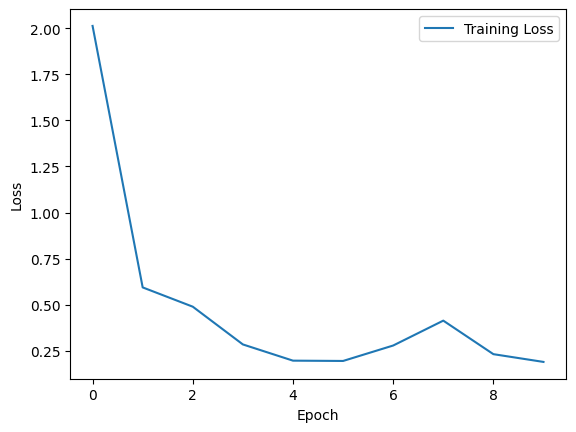

In [3]:


# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 and modify for classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 without pre-trained weights
model = models.resnet50(pretrained=False)

# Load the pre-trained weights from the downloaded file
model.load_state_dict(torch.load('resnet50-19c8e357.pth', map_location=device, weights_only= False))

# Move the model to the desired device (GPU/CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return train_losses

# Evaluate function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Train and evaluate
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
evaluate_model(model, test_loader)

# Plot loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


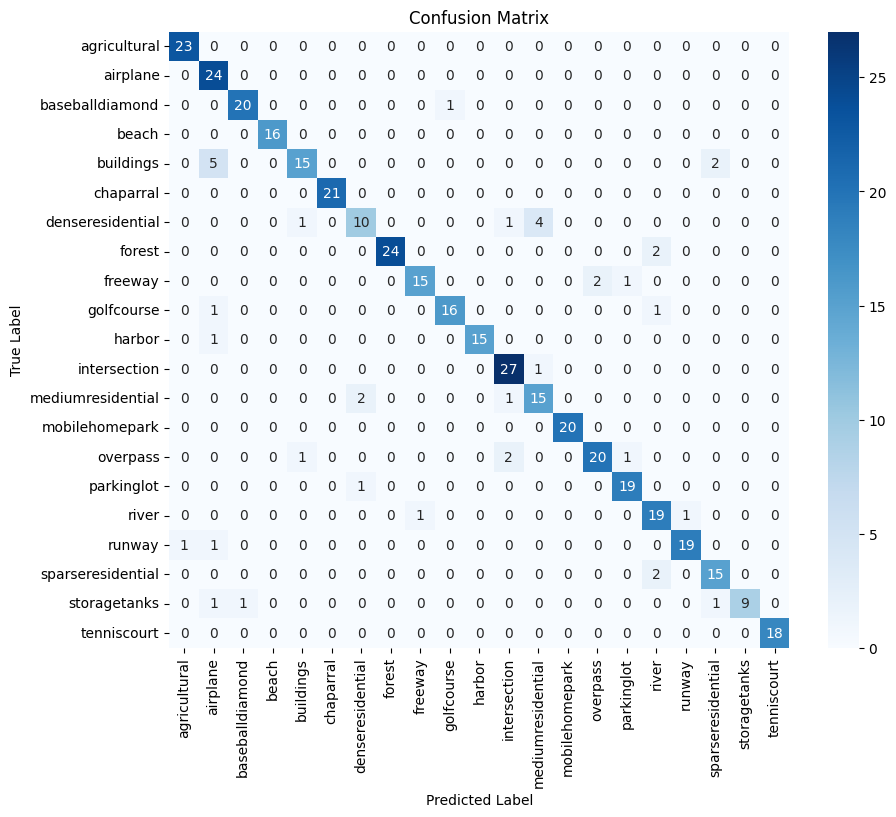

                   precision    recall  f1-score     support
agricultural        0.958333  1.000000  0.978723   23.000000
airplane            0.727273  1.000000  0.842105   24.000000
baseballdiamond     0.952381  0.952381  0.952381   21.000000
beach               1.000000  1.000000  1.000000   16.000000
buildings           0.882353  0.681818  0.769231   22.000000
chaparral           1.000000  1.000000  1.000000   21.000000
denseresidential    0.769231  0.625000  0.689655   16.000000
forest              1.000000  0.923077  0.960000   26.000000
freeway             0.937500  0.833333  0.882353   18.000000
golfcourse          0.941176  0.888889  0.914286   18.000000
harbor              1.000000  0.937500  0.967742   16.000000
intersection        0.870968  0.964286  0.915254   28.000000
mediumresidential   0.750000  0.833333  0.789474   18.000000
mobilehomepark      1.000000  1.000000  1.000000   20.000000
overpass            0.909091  0.833333  0.869565   24.000000
parkinglot          0.90

In [6]:
import pandas as pd

# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Call the function
df_results = evaluate_model_with_metrics(model, test_loader, class_names)

# Display results table
print(df_results)
